# Topic Modeling with Latent Dirichlet Allocation (LDA)
* automatic scoring with LDA

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import re
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation

import language_check

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split

import pyLDAvis
from pyLDAvis.sklearn import prepare

plt.style.use('seaborn-colorblind')

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', 100)

pyLDAvis.enable_notebook()
# plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi']= 100

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [2]:
training_set  = pd.read_csv('kaggle-dataset/training_set_rel3.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic', 'domain1_score': 'target_score', 'domain2_score': 'topic2_target'})
training_set.sample()

,essay_id,topic,essay,rater1_domain1,rater2_domain1,rater3_domain1,target_score,rater1_domain2,rater2_domain2,topic2_target,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
5405,8959,4,"In this short story, Saeng vows to take the test again in the spring because she knows that she ...",3,2,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Essay processing:

1. Language correction with languagetool (add number of corrections as feature)
2. Sentence tokenization with Spacy
3. Sentence count and length
4. Word tokenize with Spacy
5. Word token classification (punctuation, stop words and anonymized entities, pos, ent)
6. Document similarity (based on arbitrary high scoring essay for each topic)

## Grammar and spelling

As to be expected with student essays, many essays exhibit grammar and spelling errors. 

Parts-of-speech (POS) and named-entity-recognition (NER) is hampered in part by the lack of consitent spelling and punctuation. Therefore, the essays will be corrected using languagetool and the nlp parsing will be performed with Spacy on the corrected essays.

In [10]:
text = 'Some people are still using Myspoce instead of facdbook'

Textblob is an open source nlp package and something to keep an eye on. Unlike Spacy, textblob includes a statistics based spell checker. It only claims 70% accuracy, and in my testing it didn't perform well.

https://textblob.readthedocs.io/en/dev/

In [11]:
from textblob import TextBlob
data = TextBlob(text)
print (data.correct())

Some people are still using Myspoce instead of facdbook


Languagetool.org has a python wrapper for spelling and grammatical errors at 
https://github.com/myint/language-check

It appears to work quite well, although it requires intermediate storage of a list of errors ('matches').

In [12]:
tool = language_check.LanguageTool('en-US')

matches = tool.check(text)
language_check.correct(text, matches)

'Some people are still using MySpace instead of Facebook'

In [13]:
text = training_set.essay[1871]
text

'I do think that there should be a censorship in not just in libaries, but everywhare.       Personlly, I think that the way that the libraries have the books are appropite and if the parents do not want thier children going any where  that is not privy to them keep a hand lenght away     As for the parents, the parents know the aera that intrest them ,therefor the parents should go there'

In [14]:

matches = tool.check(text)
language_check.correct(text, matches)


'I do think that there should be a censorship in not just in libraries, but everywhere.  Personally, I think that the way that the libraries have the books are appropriate and if the parents do not want their children going anywhere that is not privy to them keep a hand length away As for the parents, the parents know the area that interest them,therefor the parents should go there'

As seen in the last sentence, languagetool did not correct `",therefor"`. Nonetheless, it should be good enough to proceed.

In [15]:
"""
use language tool to correct for most spelling and grammatical errors. Also count the applied corrections. 
Using language_check python wrapper for languagetool:
https://www.languagetool.org/dev
"""
tool = language_check.LanguageTool('en-US')

t0 = datetime.now()

training_set['matches'] = training_set['essay'].apply(lambda txt: tool.check(txt))
training_set['corrections'] = training_set.apply(lambda l: len(l['matches']), axis=1)
training_set['corrected'] = training_set.apply(lambda l: language_check.correct(l['essay'], l['matches']), axis=1)

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

# save work
training_set.to_pickle('training_corr.pkl')

Processing time: 0:14:07.330476


Here's a very special example of poor writing skills (or perhaps a digitization error?). None of the spell checkers I tried were able to make much sense out of this.

In [16]:
print('Original:')
print(training_set.essay[18])
print('Corrected with languagetool:')
print(training_set.corrected[18])

Original:
I aegre waf the evansmant ov tnachnolage. The evansmant ov tnachnolige is being to halp fined a kohar froi alnsas. Tnanchnolage waf ont ot we wod not go to the moon. Tnachnologe evans as we maech at. The people are in tnacholege to the frchr fror the good ov live. Famas invanyor ues tnacholage leki lena orde dvanse and his fling mashine. Tnachologe is the grat
Corrected with languagetool:
I Segre weigh the evansmant of tnachnolage. The evansmant of tnachnolige is being to half fined a coheir from Kansas. Tnanchnolage weigh Ont OT we won not go to the moon. Tnachnologe Evans as we match at. The people are in tnacholege to the arch for the good of live. Lamas inventor us tnacholage Levi Lena order dance and his fling machine. Tnachologe is the great


## NLP with SpaCy

Although much of the analysis could be performed with other NLP packages, SpaCy was chosen due to its combination of speed and simplicity.

In [17]:
training_set = pd.read_pickle('training_corr.pkl')

In [18]:
sents = []
tokens = []
lemma = []
pos = []
ner = []

stop_words = set(STOP_WORDS)
stop_words.update(punctuation) # remove it if you need punctuation 

nlp = spacy.load('en_core_web_sm')

t0 = datetime.now()

# suppress numpy warnings
np.warnings.filterwarnings('ignore')

for essay in nlp.pipe(training_set['corrected'], batch_size=100, n_threads=3):
    if essay.is_parsed:
        tokens.append([e.text for e in essay])
        sents.append([sent.string.strip() for sent in essay.sents])
        pos.append([e.pos_ for e in essay])
        ner.append([e.text for e in essay.ents])
        lemma.append([n.lemma_ for n in essay])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        sents.append(None)
        ner.append(None)

training_set['tokens'] = tokens
training_set['lemma'] = lemma
training_set['pos'] = pos
training_set['sents'] = sents
training_set['ner'] = ner

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

Processing time: 0:10:03.031798


In [19]:
training_set.to_pickle('training_spacy.pkl')

In [20]:
training_set = pd.read_pickle('training_spacy.pkl')

In [21]:
training_set[['tokens', 'pos', 'sents', 'ner']].head()

,tokens,pos,sents,ner
0,"[Dear, local, newspaper, ,, I, think, effects, computers, have, on, people, are, great, learning...","[ADJ, ADJ, NOUN, PUNCT, PRON, VERB, NOUN, NOUN, VERB, ADP, NOUN, VERB, ADJ, NOUN, NOUN, SYM, NOU...","[Dear local newspaper, I think effects computers have on people are great learning skills/affect...","[Facebook, MySpace, all day]"
1,"[Dear, @CAPS1, @CAPS2, ,, I, believe, that, using, computers, will, benefit, us, in, many, ways,...","[ADJ, PROPN, PUNCT, PUNCT, PRON, VERB, ADP, VERB, NOUN, VERB, VERB, PRON, ADP, ADJ, NOUN, ADP, V...","[Dear @CAPS1 @CAPS2, I believe that using computers will benefit us in many ways like talking an...","[Facebook, MySpace, millions, one, MySpace, Facebook, one, millions, @MONTH1, @LOCATION2, A Mill..."
2,"[Dear, ,, @CAPS1, @CAPS2, @CAPS3, More, and, more, people, use, computers, ,, but, not, everyone...","[ADJ, PUNCT, PROPN, PUNCT, PROPN, ADJ, CCONJ, ADJ, NOUN, VERB, NOUN, PUNCT, CCONJ, ADV, NOUN, VE...","[Dear, @CAPS1 @CAPS2 @CAPS3 More and more people use computers, but not everyone agrees that thi...","[today, one, @CAPS4, one, @MONTH1, thousand, @ORGANIZATION1]"
3,"[Dear, Local, Newspaper, ,, @CAPS1, I, have, found, that, many, experts, say, that, computers, d...","[ADJ, PROPN, PROPN, PUNCT, PROPN, PRON, VERB, VERB, ADP, ADJ, NOUN, VERB, ADP, NOUN, VERB, ADV, ...","[Dear Local Newspaper, @CAPS1, I have found that many experts say that computers do not benefit ...","[Dear Local Newspaper, @PERSON1, @PERSON2, @CAPS4, @LOCATION2, @PERCENT3, @LOCATION1, A+, Newspa..."
4,"[Dear, @LOCATION1, ,, I, know, having, computers, has, a, positive, effect, on, people, ., The, ...","[ADJ, ADP, PUNCT, PRON, VERB, VERB, NOUN, VERB, DET, ADJ, NOUN, ADP, NOUN, PUNCT, DET, NOUN, VER...","[Dear @LOCATION1, I know having computers has a positive effect on people., The computers connec...","[First, @NUM1 hours, one, Mae, Secondly, @LOCATION2, one, one]"


# Topic Modeling with Latent Dirichlet Allocation

Latent Dirichlet Allocation, or **LDA**, uses probabilities to allocate any number of documents to a pre-defined number of topics. A very good explanation is given here:

https://tedunderwood.com/2012/04/07/topic-modeling-made-just-simple-enough/

The *Hewlett ASAP* essays are already labeled as belonging to one of eight topics. A baseline excercise will determine how well essays are allocated to a topic using LDA.

A second experiment will be performed using LDA to assign scores.

Another important remark is that LDA is based on probability distributions. Probing these distributions introduces randomness so the results of running this notebook might not exactly match the comments or annotations.

To minimize confusion between the *LDA* derived topics and the *Hewlett ASAP* given topics, the given topic numbers will be replaced with a one-word summary.

LDA uses the probability of finding certain words associated with documents. Stop words will not be very helpful, for example, the word "the" is going to have a high probability across all topics. In order to refine the word list, we'll also use the lemma generated by SpaCy instead of the regular essay. As a reminder, the lemma were generated on language corrected essays.

In [22]:
# Replace topic numbers with meaningful one-word summary:
topic_dict = {'topic':{1: 'computer', 
                       2: 'censorship', 
                       3: 'cyclist', 
                       4: 'hibiscus', 
                       5: 'mood', 
                       6: 'dirigibles', 
                       7: 'patience', 
                       8: 'laughter'}}

training_set.replace(topic_dict, inplace=True)

# Lemmatized essays re-joined (list to essay)
training_set['l_essay'] = training_set['lemma'].apply(' '.join)

Convert essays to a matrix of token (lemma) counts:

In [23]:
# Baseline: number of unique lemma
vectorizer = CountVectorizer(max_df=.2, 
                             min_df=3, 
                             stop_words=STOP_WORDS, 
                             max_features=2000) # default: binary=False
doc_term_matrix = vectorizer.fit_transform(training_set.l_essay) # using lemmatized essays

# Most frequent tokens:
words = vectorizer.get_feature_names()
doc_term_matrix_df = pd.SparseDataFrame(doc_term_matrix, columns=words)
word_freq = doc_term_matrix_df.sum(axis=0).astype(int)
word_freq.sort_values(ascending=False).head(10) 

computer     20364
book         14001
building      7808
library       7562
dirigible     6275
read          6130
child         5762
help          5203
offensive     5115
talk          4977
dtype: int32

Apply LDA on the word frequency matrix.

In [24]:
lda_base = LatentDirichletAllocation(n_components=8,
                                     n_jobs=-1,
                                     learning_method='batch',
                                     max_iter=40,
                                     perp_tol=0.01,
                                     verbose=1,
                                     evaluate_every=5)
lda_base.fit(doc_term_matrix)

# save base model
joblib.dump(lda_base, 'lda_baseline.pkl')

iteration: 1 of max_iter: 40
iteration: 2 of max_iter: 40
iteration: 3 of max_iter: 40
iteration: 4 of max_iter: 40
iteration: 5 of max_iter: 40, perplexity: 396.4384
iteration: 6 of max_iter: 40
iteration: 7 of max_iter: 40
iteration: 8 of max_iter: 40
iteration: 9 of max_iter: 40
iteration: 10 of max_iter: 40, perplexity: 387.6358
iteration: 11 of max_iter: 40
iteration: 12 of max_iter: 40
iteration: 13 of max_iter: 40
iteration: 14 of max_iter: 40
iteration: 15 of max_iter: 40, perplexity: 387.3376
iteration: 16 of max_iter: 40
iteration: 17 of max_iter: 40
iteration: 18 of max_iter: 40
iteration: 19 of max_iter: 40
iteration: 20 of max_iter: 40, perplexity: 387.2330
iteration: 21 of max_iter: 40
iteration: 22 of max_iter: 40
iteration: 23 of max_iter: 40
iteration: 24 of max_iter: 40
iteration: 25 of max_iter: 40, perplexity: 387.1749
iteration: 26 of max_iter: 40
iteration: 27 of max_iter: 40
iteration: 28 of max_iter: 40
iteration: 29 of max_iter: 40
iteration: 30 of max_iter: 40

['lda_baseline.pkl']

Topic probabilities for all words. The numbered topics are generated from the latent Dirichlet allocation. 

In [25]:
topic_labels = ['Topic {}'.format(i) for i in range(1, 9)]
topics_count = lda_base.components_
topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=words,
                      columns=topic_labels)
topics.sample(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
minor,1.507076e-04,0.000003,0.000028,5.680529e-05,0.000067,0.000002,0.000023,0.000002
vow,1.685977e-03,0.000003,0.000001,7.512121e-07,0.000002,0.000002,0.000001,0.000002
smart,1.792769e-04,0.000448,0.000065,1.503492e-04,0.000374,0.000002,0.000659,0.000093
bear,5.742768e-05,0.000842,0.000032,3.094863e-04,0.000002,0.001499,0.000265,0.000020
engine,5.606097e-07,0.000003,0.000001,5.825088e-05,0.000002,0.000002,0.000785,0.000002
somebody,5.488834e-04,0.000003,0.000020,3.873019e-04,0.000207,0.000018,0.000317,0.000002
tomorrow,5.609983e-07,0.000388,0.000001,3.139983e-04,0.000002,0.000002,0.000211,0.000002
object,2.771226e-04,0.000317,0.000151,2.039656e-05,0.000040,0.000002,0.000121,0.000064
proper,1.093197e-04,0.000003,0.000090,1.203972e-05,0.000211,0.000018,0.000057,0.000087
apart,9.725760e-05,0.000160,0.000056,2.862382e-04,0.000358,0.000034,0.000086,0.000117


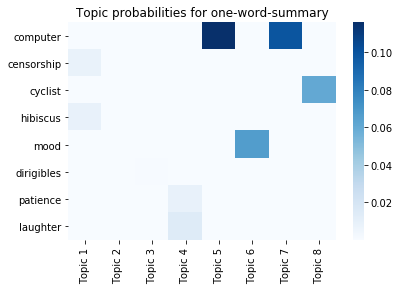

In [26]:
one_word = list(topic_dict['topic'].values())
sns.heatmap(topics.reindex(one_word), cmap='Blues')
plt.title('Topic probabilities for one-word-summary')
plt.show()

The heatmap suggests assignments for all but 1 topics. 

Below are the most probable words for each topic. We can already see our one-word summaries of the actual topic near the top of the list. 

In [27]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
0,book,caps3,building,laugh,computer,mood,computer,cyclist
1,library,caps4,dirigible,patient,spend,memoir,help,water
2,read,caps5,obstacle,wait,exercise,love,learn,setting
3,offensive,caps6,empire,laughter,kid,narcs,talk,affect
4,child,person1,mast,tell,bad,create,information,feature
5,movie,person2,builder,mom,outside,grateful,online,road
6,shelf,caps7,face,start,nature,happy,hand,hill
7,music,organization1,dock,person1,play,rodriguez,place,desert
8,material,caps8,mooring,patience,reason,house,world,hot
9,magazine,caps9,wind,feel,child,paragraph,reason,town


Now we can assign LDA topic probabilities to each essay and aggregate. It is now clear that, for example, LDA allocated topic 3 is aligned with the given topic "computers".

In [28]:
train_preds = lda_base.transform(doc_term_matrix)
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=training_set.topic)
train_eval.sample(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
topic,,,,,,,,
computer,0.001149,0.001147,0.001148,0.001148,0.440254,0.001149,0.552857,0.001148
dirigibles,0.002605,0.002606,0.981761,0.002605,0.002606,0.002605,0.002605,0.002607
mood,0.002552,0.002552,0.002552,0.002553,0.002553,0.982134,0.002553,0.002551
mood,0.002051,0.002050,0.002050,0.002052,0.002052,0.985644,0.002051,0.002051
cyclist,0.005209,0.005210,0.005213,0.005226,0.005210,0.005209,0.005213,0.963509
censorship,0.773385,0.048939,0.000913,0.046385,0.033712,0.000915,0.094839,0.000913
computer,0.001171,0.117966,0.001170,0.001170,0.133341,0.001169,0.742844,0.001170
computer,0.096735,0.067008,0.000969,0.000971,0.000971,0.000971,0.831404,0.000970
patience,0.005685,0.005684,0.005683,0.960209,0.005685,0.005685,0.005684,0.005684


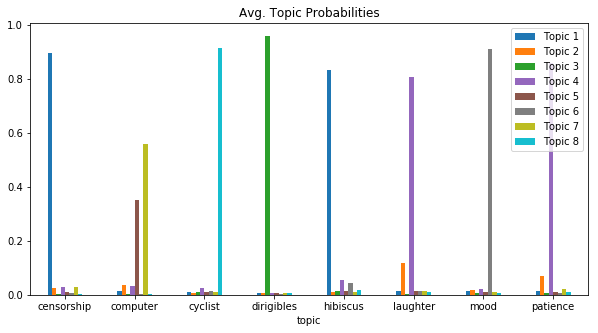

In [29]:
train_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Probabilities', rot=0, colormap='tab10', figsize=(10,5));

The baseline model was successful in that each given topic is allocated with high probability to an LDA topic:

,topic,assignment
0,censorship,Topic 1
1,computer,Topic 7
2,cyclist,Topic 8
3,dirigibles,Topic 3
4,hibiscus,Topic 1
5,laughter,Topic 4
6,mood,Topic 6
7,patience,Topic 4


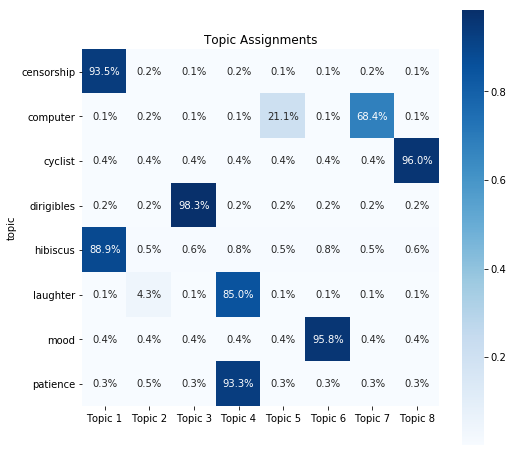

In [30]:
df = train_eval.groupby(level='topic').agg('median')
fig, ax = plt.subplots(figsize=(8,8))
g = sns.heatmap(df, annot=True, fmt='.1%', annot_kws={"size": 10}, cmap='Blues', square=True)
loc, labels = plt.yticks()
g.set_yticklabels(labels, rotation=0)
g.set_title('Topic Assignments');

df = train_eval\
            .idxmax(axis=1)\
            .reset_index()\
            .groupby('topic', as_index=False)\
            .agg(lambda x:x.value_counts().index[0])\
            .rename(columns={0:'assignment'})
df

## Visualization with PyLDAVis

#### Lambda

- **$\lambda$ = 0**: how probable is a word to appear in a topic - words are ranked on lift P(word | topic) / P(word)
- **$\lambda$ = 1**: how exclusive is a word to a topic -  words are purely ranked on P(word | topic)

The ranking formula is $\lambda * P(\text{word} \vert \text{topic}) + (1 - \lambda) * \text{lift}$

User studies suggest $\lambda = 0.6$ works for most people.

In [31]:
prepare(lda_base, doc_term_matrix, vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.071756 -0.123076       1        1  25.791481
3      0.080689  0.073752       2        1  19.300420
6      0.107037 -0.126833       3        1  14.366069
2     -0.375785 -0.015805       4        1  12.629813
4      0.074849 -0.098745       5        1   8.237609
5      0.056780 -0.088600       6        1   7.519359
7     -0.103776  0.055201       7        1   7.491409
1      0.088450  0.324106       8        1   4.663839, topic_info=     Category          Freq           Term         Total  loglift  logprob
term                                                                      
360   Default  20459.000000       computer  20459.000000  30.0000  30.0000
202   Default  13892.000000           book  13892.000000  29.0000  29.0000
229   Default   7777.000000       building   7777.000000  28.0000  28.0000
520   Default   6250.000000      dirigible   6250.000000  27.0000  27.0000
268   Default   4649.000000          caps3   4649.000000  26.0000  26.0000
1160  Default   4307.000000           mood   4307.000000  25.0000  25.0000
269   Default   3450.000000          caps4   3450.000000  24.0000  24.0000
446   Default   3904.000000        cyclist   3904.000000  23.0000  23.0000
1039  Default   7502.000000        library   7502.000000  22.0000  22.0000
1228  Default   3989.000000       obstacle   3989.000000  21.0000  21.0000
1017  Default   4648.000000          laugh   4648.000000  20.0000  20.0000
270   Default   2464.000000          caps5   2464.000000  19.0000  19.0000
601   Default   3443.000000         empire   3443.000000  18.0000  18.0000
1942  Default   2889.000000          water   2889.000000  17.0000  17.0000
1236  Default   5073.000000      offensive   5073.000000  16.0000  16.0000
1128  Default   2581.000000         memoir   2581.000000  15.0000  15.0000
1078  Default   3709.000000           love   3709.000000  14.0000  14.0000
1111  Default   2978.000000           mast   2978.000000  13.0000  13.0000
1308  Default   3614.000000        person1   3614.000000  12.0000  12.0000
271   Default   1905.000000          caps6   1905.000000  11.0000  11.0000
1584  Default   2172.000000        setting   2172.000000  10.0000  10.0000
1287  Default   3266.000000        patient   3266.000000   9.0000   9.0000
228   Default   2571.000000        builder   2571.000000   8.0000   8.0000
47    Default   2427.000000         affect   2427.000000   7.0000   7.0000
1178  Default   1952.000000          narcs   1952.000000   6.0000   6.0000
1689  Default   2375.000000          spend   2375.000000   5.0000   5.0000
541   Default   2388.000000           dock   2388.000000   4.0000   4.0000
421   Default   2376.000000         create   2376.000000   3.0000   3.0000
1162  Default   2322.000000        mooring   2322.000000   2.0000   2.0000
1595  Default   3293.000000          shelf   3293.000000   1.0000   1.0000
...       ...           ...            ...           ...      ...      ...
262    Topic8    124.196788         caps18    125.069671   3.0583  -5.7750
261    Topic8    123.171418         caps17    124.044309   3.0583  -5.7833
265    Topic8    108.816368         caps21    109.689253   3.0573  -5.9072
263    Topic8     94.461324         caps19     95.334197   3.0561  -6.0487
1312   Topic8     90.359737        person5     91.232749   3.0557  -6.0931
264    Topic8     80.106266         caps20     80.979141   3.0545  -6.2135
266    Topic8     67.801938         caps22     68.674807   3.0525  -6.3803
267    Topic8     50.370793         caps24     51.243667   3.0482  -6.6775
269    Topic8   3283.128967          caps4   3450.854224   3.0155  -2.5003
1309   Topic8   1364.864900        person2   1507.003828   2.9663  -3.3781
268    Topic8   3705.180065          caps3   4649.370656   2.8383  -2.3794
787    Topic8     35.247244         glance     53.760831   2.6432  -7.0345
860    Topic8     31.588467          hello

### "Score Allocation"

Can we take this to the next level and assign target scores based on word probabilities? To keep it simple, we'll limit the essays to topic number 4, "hibiscus". This topic has only four target scores and a reasonably balanced distribution.

In [34]:
hibiscus = training_set[training_set.topic == 'hibiscus']

# Split essays into training and test sets
train_essays, test_essays = train_test_split(hibiscus, 
                                         stratify=hibiscus.target_score, 
                                         test_size=0.2, 
                                         random_state=42)

In [35]:
vectorizer = CountVectorizer(max_df=.2, 
                             min_df=3, 
                             stop_words=STOP_WORDS, 
                             max_features=400) # limit to account for smaller set of essays

# Train and test doc-term matrices
train_dtm = vectorizer.fit_transform(train_essays.l_essay)
test_dtm = vectorizer.fit_transform(test_essays.l_essay)

In [36]:
lda_score = LatentDirichletAllocation(n_components=4,
                                     n_jobs=-1,
                                     learning_method='batch',
                                     evaluate_every=5,
                                     verbose=1, 
                                     max_iter=500)
lda_score.fit(train_dtm)

# save training model
joblib.dump(lda_score, 'lda_score.pkl')

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500, perplexity: 289.0970
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 279.5138
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500, perplexity: 273.1729
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 270.1631
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500, perplexity: 268.8611
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter: 500


['lda_score.pkl']

In [39]:
topic_labels = ['Score A', 'Score B', 'Score C', 'Score D'] #.format(i) for i in range(1, 5)]

train_preds = lda_score.transform(train_dtm)
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_essays.target_score)
train_eval.sample(5)

,Score A,Score B,Score C,Score D
target_score,,,,
1,0.660247,0.025972,0.026131,0.287649
2,0.014167,0.122066,0.566254,0.297513
0,0.042368,0.043872,0.559395,0.354365
1,0.015324,0.535914,0.016749,0.432014
2,0.723890,0.014013,0.013799,0.248298


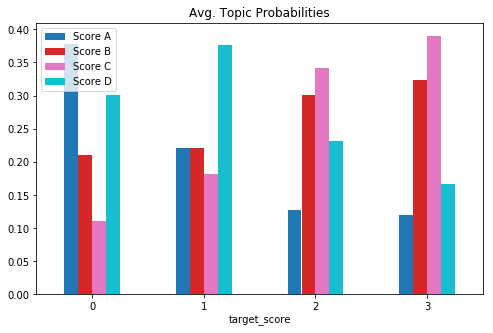

In [40]:
train_eval.groupby(level='target_score')\
            .mean()\
            .plot\
            .bar(title='Avg. Topic Probabilities', rot=0, colormap='tab10', figsize=(8,5));

,target_score,assignment
0,0,Score A
1,1,Score D
2,2,Score C
3,3,Score C


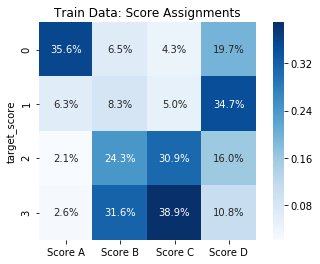

In [41]:
df = train_eval.groupby(level='target_score').agg('median')
sns.heatmap(df, annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Train Data: Score Assignments');

df = train_eval\
            .idxmax(axis=1)\
            .reset_index()\
            .groupby('target_score', as_index=False)\
            .agg(lambda x:x.value_counts().index[0])\
            .rename(columns={0:'assignment'})
df

In [42]:
test_preds = lda_score.transform(test_dtm)
test_eval = pd.DataFrame(test_preds, columns=topic_labels, index=test_essays.target_score)
test_eval.head()

,Score A,Score B,Score C,Score D
target_score,,,,
2,0.011977,0.254760,0.347584,0.385679
3,0.286519,0.353608,0.170209,0.189664
0,0.607361,0.133645,0.133992,0.125002
1,0.202250,0.137793,0.318266,0.341692
1,0.620999,0.032699,0.313826,0.032476


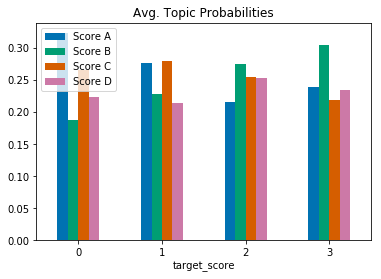

In [43]:
test_eval.groupby(level='target_score')\
            .mean()\
            .plot\
            .bar(title='Avg. Topic Probabilities', rot=0);

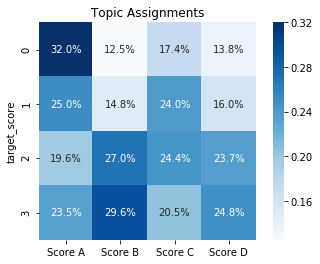

In [44]:
df = test_eval.groupby(level='target_score').agg('median')
sns.heatmap(df, annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Topic Assignments')
plt.show()

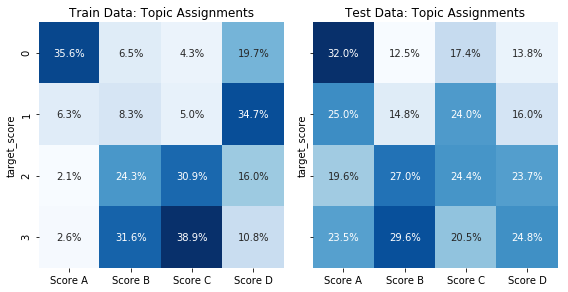

In [45]:
fig, axes = plt.subplots(ncols=2, figsize=(8,6), sharey=True)
source = ['Train', 'Test']
for i, df in enumerate([train_eval, test_eval]):
    df = df.groupby(level='target_score').agg('median')
    sns.heatmap(df, annot=True, fmt='.1%', cmap='Blues', square=True, ax=axes[i], cbar=False)
    axes[i].set_title('{} Data: Topic Assignments'.format(source[i]))
plt.tight_layout()
plt.show()

While the charts above are very similar to a confusion matrix, the ordering of the LDA derived topics (A,B,C,D) doesn't necessarily match the human-labeled topic ordering (0,1,2,3). Thus, the high percentages, shown here as deep blues, are not expected to be found along the diagonal. Instead the goal is to find topic distinction, indicated by a single dark square in each column, and model accuracy, indicated by identical color patterns between train and test data sets.

As seen above, there is some agreement between train and test data that essays with highest and lowest scores are distinct and assigned "Score A" and "Score B" respectively.  Overall, both topic distinction and model accuracy are rather poor. It is highly improbable this approach could be extended to any of the other topics due to the larger range of scores and class imbalance. 

Furthermore, repeated LDA runs show a lack of reproducability, which is a sign of poor distinction of topics. In summary, topic modelling, or more specifically using word frequencies and probabilities is not a useful tool to grade student essays. In the next notebook we'll continue with machine learning algorithms.